In [1]:
%matplotlib inline
import argparse
import numpy as np
import math
import matplotlib.pyplot as plt

from datetime import datetime
import time

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch

import os
from PIL import Image
from tqdm.notebook import tqdm
cuda = torch.device('cuda:0')

In [2]:
import pickle
import pandas as pd
import os
from skimage.io import imread
from  torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms

In [3]:
import sys
sys.path.append("..")
from utils.CUBDataset import CUBDataset, image_dim

In [ ]:
!pip3 install -U sentence-transformers

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sentence_transformers import SentenceTransformer

In [6]:
import torch
from torch import nn
class ConvAE(nn.Module):
    """
    Convolutional AE
    """
    
    #generator model
    def __init__(self):
        super(ConvAE,self).__init__()
        self.embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
        for p in self.embedder.parameters():
            p.requires_grad = False
            pass
        
        self.e1=nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.LeakyReLU(0.2,inplace=True)
        )
        
        self.e2=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.e3=nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.e4=nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2,inplace=True)
        )
        self.e5=nn.Sequential(
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2,inplace=True)
            
        )
        
        self.caption_fc = nn.Linear(768,24*24)
        
        self.d1=nn.Sequential(
            nn.ConvTranspose2d(in_channels=513,out_channels=256,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU()
        )

        self.d2=nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(5,5),stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU()
        )
        self.d3=nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.d4=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU()
        )
        self.d5=nn.Sequential(
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
            nn.Tanh()
        )

    def forward(self,x, caption):
        x=self.e1(x)
        x=self.e2(x)
        x=self.e3(x)
        x=self.e4(x)
        x=self.e5(x)
        encoded_caption = self.embedder.encode(caption, convert_to_tensor=True).cuda()
        encoded_caption = self.caption_fc(encoded_caption)
#         print(x.shape, encoded_caption.shape)
        x = torch.cat((encoded_caption.view(-1, 1, 24, 24), x), 1)
        x=self.d1(x)
        x=self.d2(x)
        x=self.d3(x)
        x=self.d4(x)
        x=self.d5(x)
        x = (x + 1) / 2
        return x #output of generator

In [7]:
def PSNRLoss(original, inpainted): 
    eps = 1e-11
    mse = torch.mean((original - inpainted)**2)
    psnr = 20 * torch.log10(1/torch.sqrt(mse+eps)) 
    return -psnr

In [8]:
stage_1_epochs = 1 # number of epochs of training on full images
stage_2_epochs = 20 # number of epochs of training on partial images
batch_size = 64 # size of the batches
n_cpu = 8 # number of cpu threads to use during batch generation

# Adam parameters
lr = 0.001 # adam: learning rate
b1 = 0.9 # adam: decay of first order momentum of gradient
b2 = 0.999 # adam: decay of first order momentum of gradient

sample_interval = 500 # interval betwen image samples

In [9]:
# Loss function
mse = torch.nn.MSELoss()

# Initialize generator and discriminator
model = ConvAE()

model.cuda()
mse.cuda()

r_losses = []
times = []

# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))

In [10]:
def show_checkpoint_repros(model):
    birb = Image.open("../CUB_200_2011/Vermilion_Flycatcher_0042_42266.jpg") # picture of a room from the validation set.
    caption = "this bird has a red crown and flank as well as a black pointed bill and black tarsus." # I wrote a caption for it
    birb = birb.convert("RGB")
    birb = birb.resize((224,224))

    tr = transforms.ToTensor()
    birb_t = tr(birb)
    x1 = 112-43
    y1 = 112-43
    x2 = x1 + 86
    y2 = y1 + 86

    mask = torch.zeros(3, image_dim,image_dim,dtype=torch.bool)
    mask[:,y1:y2,x1:x2] = True
    
    masked = birb_t.detach().clone()
    masked[mask] = 1

    with torch.no_grad():
        model.eval()
        recon_full = model(birb_t.unsqueeze(0).cuda(), caption)
        recon_masked = model(masked.unsqueeze(0).cuda(), caption)

        fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,5))
        plt.suptitle(caption)
        ax1.imshow(birb_t.permute(1,2,0))
        ax1.set_title("full")
        ax2.imshow(masked.permute(1,2,0))
        ax2.set_title("masked")
        ax3.imshow(recon_full[0].cpu().permute(1,2,0))
        ax3.set_title("reconstructed full")
        ax4.imshow(recon_masked[0].cpu().permute(1,2,0))
        ax4.set_title("reconstructed masked")
        plt.show()

In [11]:
# Resume from checkpoint
model.load_state_dict(torch.load("./checkpoints/text_guided_ConAE_stage2_epoch_7_0.006335718557238579.pth"))

<All keys matched successfully>

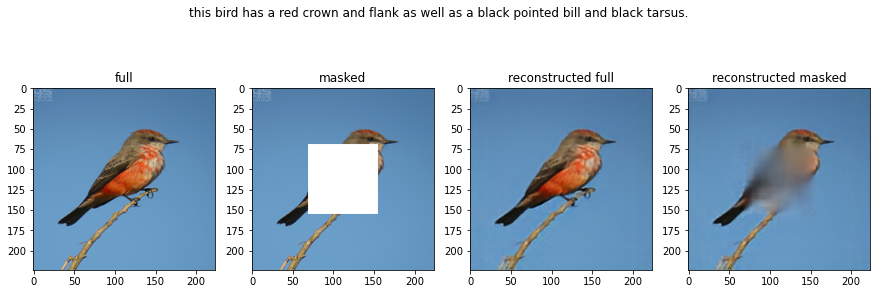

In [12]:
show_checkpoint_repros(model)

In [14]:
dataset_train = CUBDataset('../CUB_200_2011/')

trainloader = DataLoader(dataset_train,
                         batch_size=batch_size, 
                         shuffle=True, 
                         num_workers=8)

2020-11-09 02:11:39.144852 [Epoch 0/1] [Batch 0/1842] [Recon Loss: 0.357210]


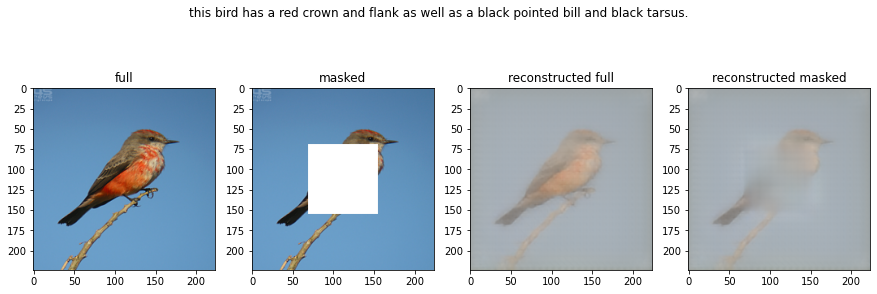

In [ ]:
# ----------
#  Training
# ----------
for epoch in tqdm(range(0, stage_1_epochs)):
    epoch_loss = 0
    for i, batch in tqdm(enumerate(trainloader), total=(len(dataset_train)//batch_size)):
        model.train()
        
        full_imgs = batch['full_images'].cuda()
        mask = batch['masks']
        masked_imgs = full_imgs.detach().clone()
        
        masked_imgs[mask] = 1.0

        optimizer.zero_grad()

        # Generate a batch of images
        gen_imgs = model(full_imgs, batch['captions'])

        #gen_rois = gen_imgs[mask]
        #full_rois = full_imgs[mask]

        recon_loss = mse(gen_imgs, full_imgs)
        epoch_loss+=recon_loss.item()
        recon_loss.backward()
        optimizer.step()

        batches_done = epoch * len(trainloader) + i
        if batches_done % sample_interval == 0:
            print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [Recon Loss: %f]" % (epoch, stage_1_epochs, i, len(trainloader), recon_loss.item()))
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            r_losses.append(recon_loss.item())
            show_checkpoint_repros(model)
            pass
        pass
    print(f"Epoch Loss: {epoch_loss/len(dataset_train)}")    
    torch.save(model.state_dict(), f"./checkpoints/text_guided_birbCoAE_epoch_{epoch}_{str(epoch_loss/len(dataset_train))}.pth")
    
    
for epoch in tqdm(range(0, stage_2_epochs)):
    epoch_loss = 0
    for i, batch in tqdm(enumerate(trainloader), total=(len(dataset_train)//batch_size)):
        
        full_imgs = batch['full_images'].cuda()
        mask = batch['masks']
        masked_imgs = full_imgs.detach().clone()
        
        masked_imgs[mask] = 1.0

        optimizer.zero_grad()

        # Generate a batch of images
        gen_imgs = model(masked_imgs, batch['captions'])
        epoch_loss+=recon_loss.item()
        
        gen_rois = gen_imgs[mask]
        full_rois = full_imgs[mask]

        recon_loss = mse(gen_imgs, full_imgs)

        recon_loss.backward()
        optimizer.step()

        batches_done = epoch * len(trainloader) + i
        if batches_done % sample_interval == 0:
            print(str(datetime.now()), "[Epoch %d/%d] [Batch %d/%d] [Recon Loss: %f]" % (epoch, stage_2_epochs, i, len(trainloader), recon_loss.item()))
            #save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            r_losses.append(recon_loss.item())
            times.append(time.time())
            show_checkpoint_repros(model)
            pass
        pass
    print(f"Epoch Loss: {epoch_loss/len(dataset_train)}")
    torch.save(model.state_dict(), f"./checkpoints/text_guided_birbCoAE_stage2_epoch_{epoch}_{str(recon_loss.item())}.pth")